In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [3]:
from typing import Tuple

import numpy as np
import pandas as pd

from statsmodels.graphics import tsaplots
from load_dataset import Dataset
import matplotlib.pyplot as plt
import plotting

from statsmodels.tsa.stattools import adfuller

### Пример работы stl
не импортировать и не запускать дальнейшие ячейки до блока "задание"

In [6]:
# from stl import detect_ts, extract_trend, extract_seasonality

#### Возьмем типичный пример ряда с трендом и сезонностью

In [7]:
dataset = Dataset('../data/dataset/')

In [8]:
ts = dataset['stl_example.csv']

/home/nikita/Документы/time_series_course/ts_march_2023/load_dataset.py:34: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  ts = pd.read_csv(


<Axes: >

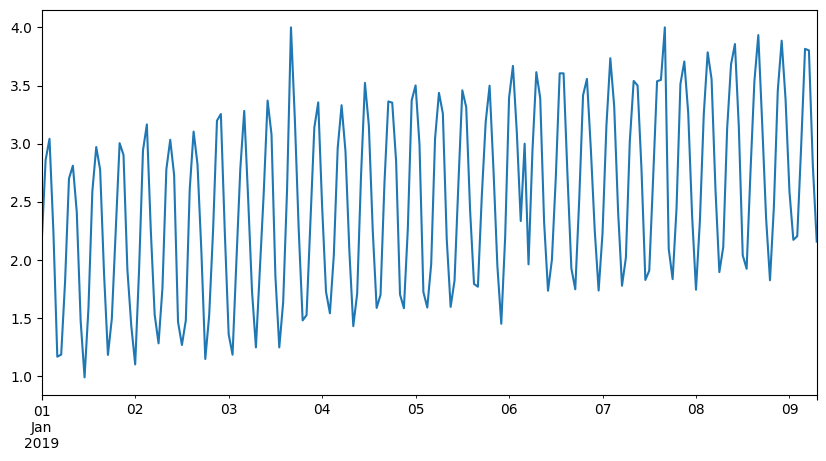

In [9]:
ts.plot(figsize=(10, 5))

#### Извлечем линейный тренд

In [25]:
trend = extract_trend(ts)[0]

<AxesSubplot:>

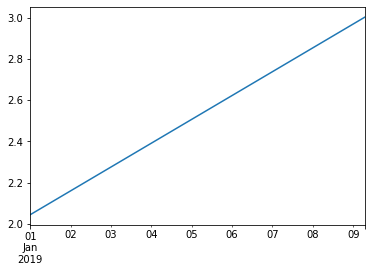

In [26]:
trend.plot()

#### Вычтем тренд из исходного ряда

In [27]:
ts_detrended = ts - trend

<AxesSubplot:>

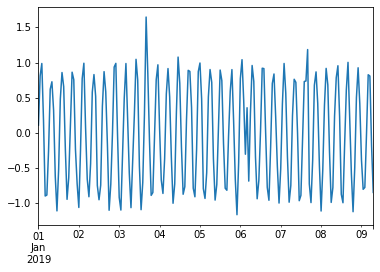

In [28]:
ts_detrended.plot()

#### Извлечем сезонность из получившегося ряда

In [29]:
season = extract_seasonality(ts_detrended, period=6)

In [30]:
season

2019-01-01 00:00:00         NaN
2019-01-01 01:00:00    0.460649
2019-01-01 02:00:00    0.898505
2019-01-01 03:00:00    0.585060
2019-01-01 04:00:00   -0.356509
                         ...   
2019-01-09 03:00:00   -0.391208
2019-01-09 04:00:00    0.409390
2019-01-09 05:00:00    0.817780
2019-01-09 06:00:00    0.312911
2019-01-09 07:00:00   -0.513971
Length: 200, dtype: float64

<AxesSubplot:>

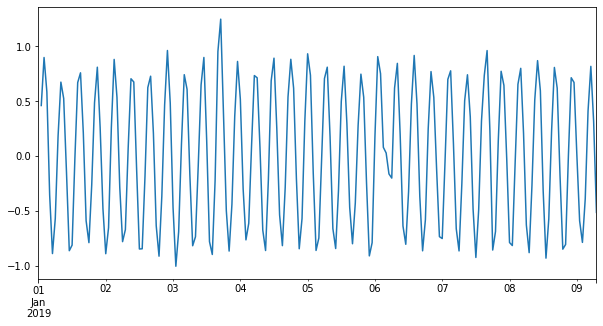

In [31]:
season.plot(figsize=(10, 5))

#### Вычтем сезонность из ряда ts_detrended и получим остатки

In [32]:
resid = ts_detrended - season

In [33]:
plotting.plot_ts(resid)

Loading BokehJS ...

#### Так как мы убрали из ряда тренд и сезонность, получившиеся остатки по идее должны быть стационарными. Давайте это проверим по критерию Дики-Фуллера.

In [34]:
adfuller(resid.dropna())

(-7.61384667534931,
 2.218522249065233e-11,
 12,
 186,
 {'1%': -3.466005071659723,
  '5%': -2.8772078537639385,
  '10%': -2.5751221620996647},
 -339.17210593343293)

### Задание 1 - реализовать "наивную" имплементацию stl-разложения:
    Ряд - stl_example.csv
  
    1. Апроксимировать ряд линейным трендом.
    2. Вычесть линейный тренд из ряда.
    3. Найти период сезонности получившегося ряда по коррелограме.
    4. Получить сезонность ряда без тренда одним из двух способов: 
       а) при помощи медианного фильтра с окном равным период/к, к подобрать (обычно 2-3)
       б) продифференцировав его с лагом, равным найденному периоду сезонности и вычтя
       получившийся ряд из исходного
       в)* попробуйте подумать, какие есть плюсы и минусы у каждого из способов?
    4. Вычесть тренд и сезонность, получить остатки.
    6. Проверить остатки на стационарность.

   
detect_ts должна возвращать tuple из: (тренд, сезонность, остатки)

In [44]:
def extract_trend(ts: pd.Series):
    """
    Извлекает линейный тренд из временного ряда
    """
    x = np.arange(len(ts))
    k, b = np.linalg.lstsq(np.vstack([x, np.ones(len(x))]).T, ts.values, rcond=None)[0]
    trend = k * x + b
    return pd.Series(trend, index = ts.index), k, b

Text(0.5, 1.0, 'extracted trend')

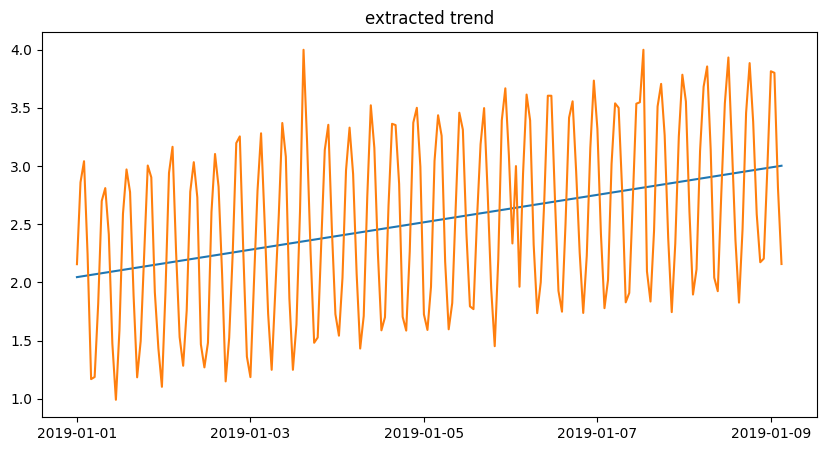

In [140]:
trend = extract_trend(ts)[0]
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ts.index, trend)
ax.plot(ts.index, ts.values)
ax.set_xticks(ts.index[::49])
ax.set_title('extracted trend')

In [47]:
detrended = ts - extract_trend(ts)[0]

<Axes: >

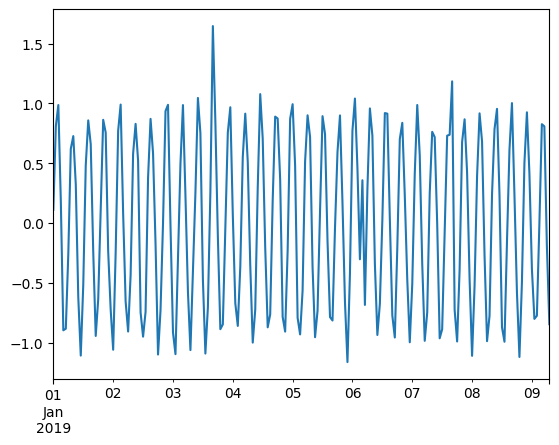

In [50]:
detrended.plot()

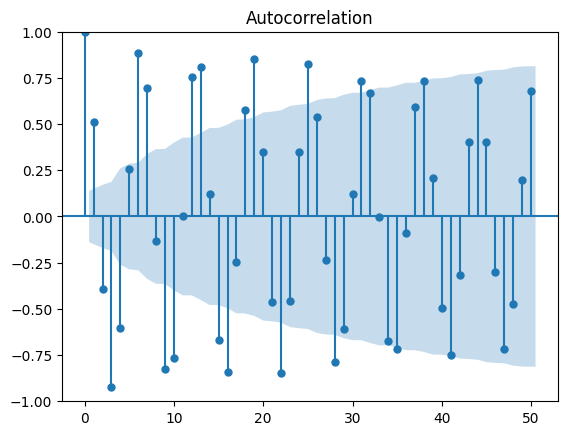

In [55]:
tsaplots.plot_acf(detrended, lags=50);

In [56]:
#сезонность = 6

In [112]:
def extract_seasonality(ts_detrended, period=None):
    """
    Извлекает сезонную компоненту
    """
    means = []
    for i in range(period):
        means.append(detrended[i::period].mean())
    
    season = pd.Series(index = ts_detrended.index, dtype = 'float64')
    
    for i in range(len(season)):
        season.iloc[i] = means[i%period]

    return season

In [115]:
def extract_seasonality_diff(ts_detrended, period=None):
    """
    Извлекает сезонную компоненту при помощи дифференцирования
    """
    ts_diff = ts.diff(period)
    
    season = ts_detrended - ts_diff
    
    return season

In [121]:
seasonality_diff = extract_seasonality_diff(detrended, period = 6)
seasonality = extract_seasonality(detrended, period = 6)

/tmp/ipykernel_4094/2232344420.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


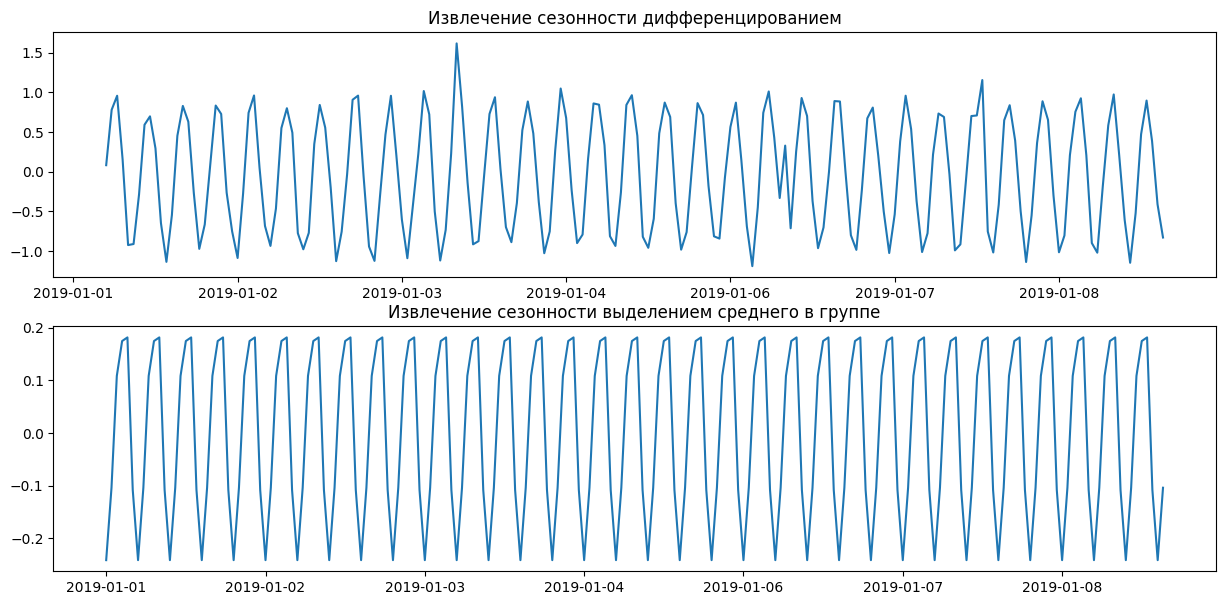

In [129]:
fig, axs = plt.subplots(2, 1, figsize = (15,7))
axs[0].plot(seasonality_diff.index, seasonality_diff)
axs[0].set_title('Извлечение сезонности дифференцированием')
axs[0].set_xticks(seasonality_diff.index[::30])

axs[1].plot(seasonality.index, seasonality)
axs[1].set_title('Извлечение сезонности выделением среднего в группе')
axs[1].set_xticks(seasonality.index[::30])

fig.show()

Кажется, что второй вариант позволит лучше убрать сезонность. \
В первом варианте из каждой точки будет вычитаться оценка отклонения из-за сезонности только по одной точке(на период назад), в во втором для оценки искпользуется вся выборка из этой группы.

In [135]:
resid = detrended - seasonality

<Axes: >

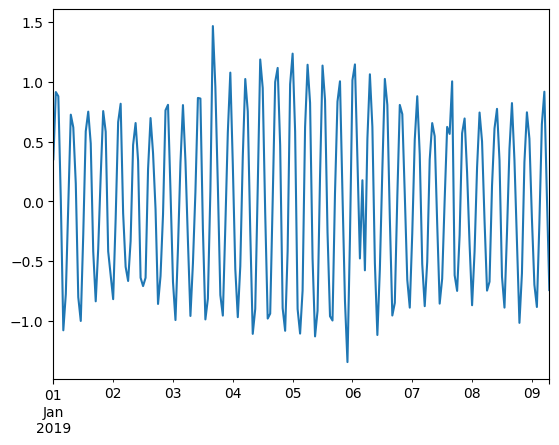

In [136]:
resid.plot()

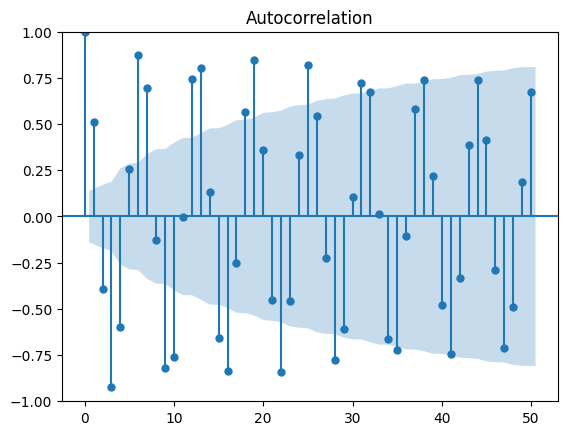

In [138]:
tsaplots.plot_acf(resid, lags=50);

In [ ]:
# по прежнему большая коррелиция с периодом 6. Почему?

### Задание 2 - найти аномалии во временном ряде при помощи получившихся остатков 

1. Расчитать стандартное отклонение остатков std
2. Получить порог на остатки по формуле `threshold = k * std`, k обычно берется от 2 до 3.
3. Найти аномалии, как точки ряда, абсолютные значения которых превышают найденный порог

In [164]:
k = 2
std = resid.std()
threshold = k * std

In [175]:
ind_anomaly = resid[resid.abs() > threshold].index

In [177]:
ts.loc[ind_anomaly]

2019-01-03 16:00:00    4.0
Name: 0, dtype: float64

In [186]:
import datetime as dt

Text(0.5, 1.0, 'detected anomaly')

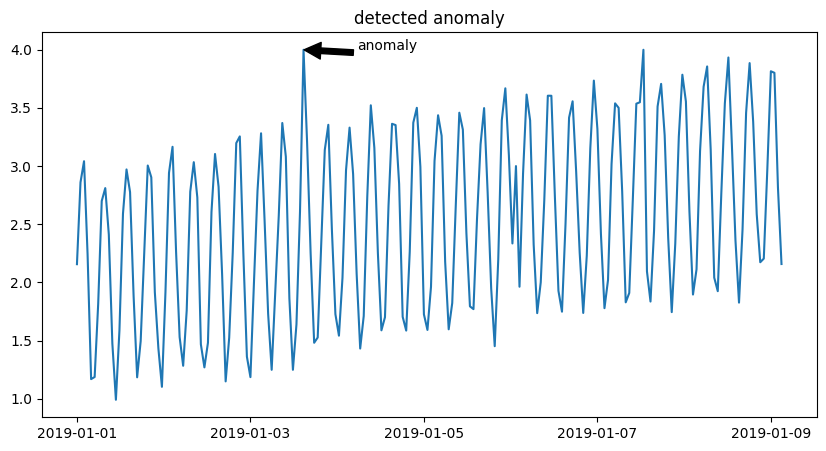

In [191]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ts)
ax.set_xticks(ts.index[::49])
ax.annotate('anomaly', xy=(ind_anomaly, ts.loc[ind_anomaly]), xytext=(ind_anomaly + dt.timedelta(hours = 15), ts.loc[ind_anomaly]),
            arrowprops=dict(facecolor='black', shrink=0.01))

ax.set_title('detected anomaly')

In [249]:
# не замечает явную аномалию в правой половине(где маленький разброс)

In [250]:
#метод с другим вариантом поиска сезонности

In [222]:
resid_diff = detrended - seasonality_diff

In [244]:
k = 3
std = resid_diff.std()
threshold = k * std

In [245]:
ind_anomaly = resid[resid_diff.abs() > threshold].index

In [246]:
ind_anomaly

DatetimeIndex(['2019-01-06 04:00:00', '2019-01-06 10:00:00',
               '2019-01-07 16:00:00'],
              dtype='datetime64[ns]', freq=None)

In [234]:
ind_anomaly[-4]

Timestamp('2019-01-06 04:00:00')

Text(0.5, 1.0, 'detected anomaly')

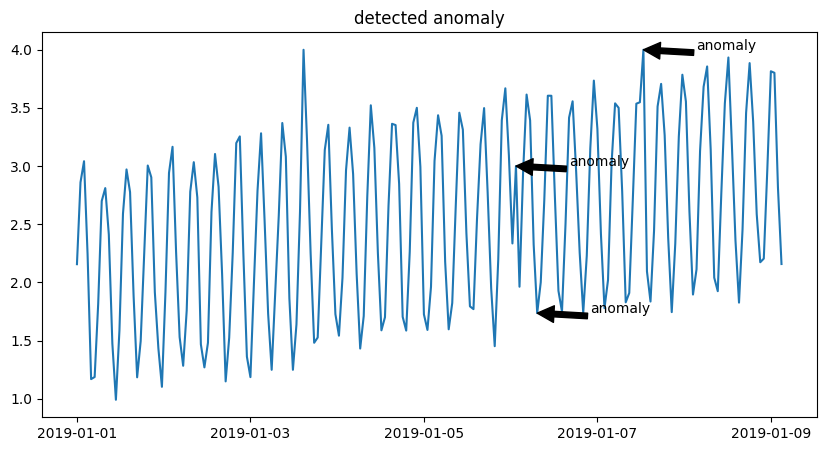

In [248]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ts)
ax.set_xticks(ts.index[::49])

for anomaly in ind_anomaly:
    ax.annotate('anomaly', xy=(anomaly, ts.loc[anomaly]),
            xytext=(anomaly + dt.timedelta(hours = 15), ts.loc[anomaly]),
            arrowprops=dict(facecolor='black', shrink=0.001))

ax.set_title('detected anomaly')

In [251]:
# теперь замечает

### Задание 3 - сделать прогноз ряда на 6 периодов вперед (36 точек)

1. Экстраполируйте линейный тренд.
2. Сделайте рекурсивный прогноз сезонной компоненты по формуле y(t) = y(t-6)
3. Остатки по-хорошему должны моделироваться моделью arma, но в нашем случае сделайте просто прогноз средним значением. (Т.к. в нашем случае это 0, остатки можно вообще проигнорировать)
4. Сложите получившиеся компоненты и получите финальный прогноз
5. profit!

### stl-Разложение "из коробки" - statsmodels. 

In [150]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [151]:
decomp = seasonal_decompose(ts, period=6)

<Axes: >

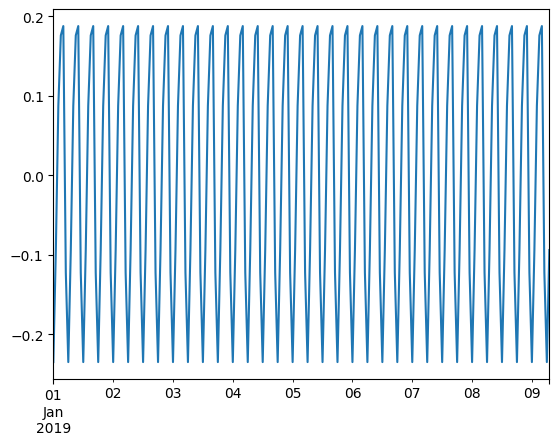

In [156]:
decomp.seasonal.plot()

<Axes: >

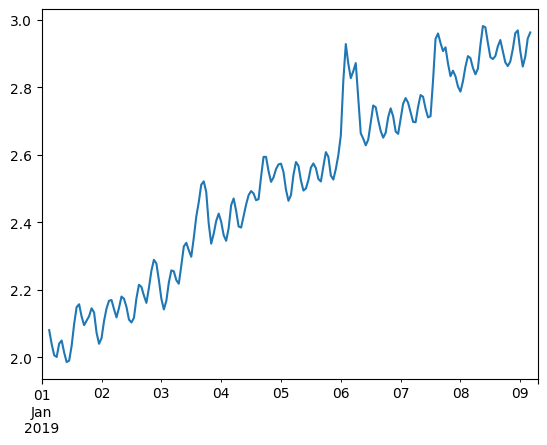

In [157]:
decomp.trend.plot()

<Axes: >

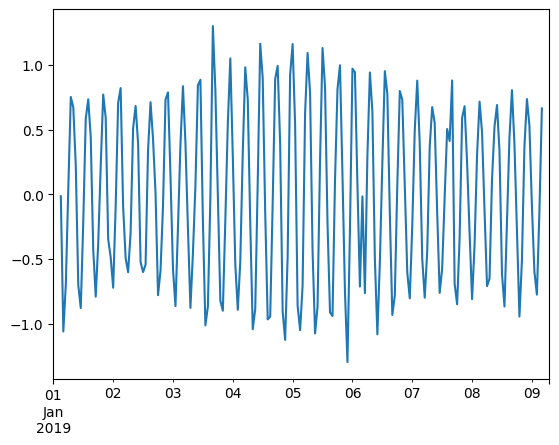

In [158]:
decomp.resid.plot()

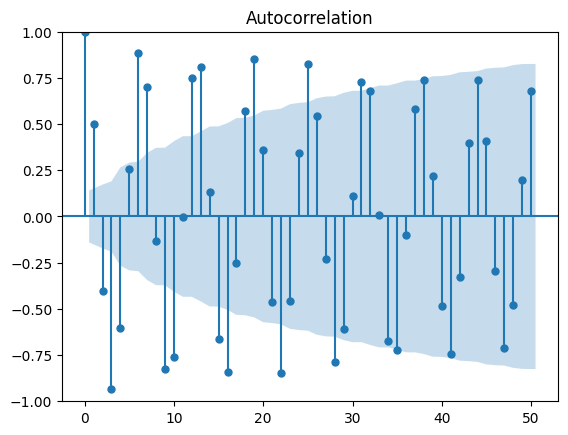

In [160]:
tsaplots.plot_acf(decomp.resid.dropna(), lags=50);

In [63]:
adfuller(decomp.resid.dropna())

(-8.636599897383757,
 5.569118685308781e-14,
 12,
 181,
 {'1%': -3.467004502498507,
  '5%': -2.8776444997243558,
  '10%': -2.575355189707274},
 -235.03526098050253)

### Другие пакеты
- stldecompose (также "наивная реализация")
- pyloess (давно не было обновлений)